In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir(r'C:\Users\thoma\OneDrive - stevens.edu\Documents\GitHub\CS513_Project')

In [3]:
df = pd.read_csv('test.csv', na_values='?')
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.dropna()

In [4]:
#Feature engineering

#Total delay rather than 
df['Total Delay'] = df['Departure Delay in Minutes'] + df['Arrival Delay in Minutes']

#Turns delay into a categorical feature 
def bucket_total_delay(minutes):
    if minutes <= 15:
        return 'On Time'
    elif minutes <= 60:
        return 'Small Delay'
    else:
        return 'Big Delay'

# Apply the function to create a new feature
df['Delay Category'] = df['Total Delay'].apply(bucket_total_delay)

def bucket_rating(x):
    if x <= 2:
        return 'Low'
    elif x == 3:
        return 'Medium'
    else:
        return 'High'

rating_columns = [ 'Inflight wifi service','Food and drink', 'Seat comfort',
                  'Inflight entertainment', 'On-board service', 'Leg room service',
                  'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

for col in rating_columns:
    df[col] = df[col].apply(bucket_rating)


In [5]:
attr = df.drop(columns=['satisfaction', 'id', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Total Delay'])
target = (df['satisfaction'] == 'satisfied').astype(int)

attr_train, attr_test, target_train, target_test = train_test_split(attr, target, test_size=0.2, random_state=5)

categorical_columns = attr.columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])

X_train = preprocessor.fit_transform(attr_train)
X_test = preprocessor.transform(attr_test)

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
#Build ANN 
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Users\thoma\anaconda3\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [7]:
history = model.fit(X_train, target_train, epochs=30, batch_size=32,
                    validation_split=0.2, verbose=1)

loss, accuracy = model.evaluate(X_test, target_test)
print(f'Test Accuracy: {accuracy:.4f}')

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(target_test, y_pred))
print(confusion_matrix(target_test, y_pred))


Epoch 1/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7915 - loss: 0.4506 - val_accuracy: 0.8590 - val_loss: 0.3317
Epoch 2/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9187 - loss: 0.2001 - val_accuracy: 0.8687 - val_loss: 0.3387
Epoch 3/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9319 - loss: 0.1650 - val_accuracy: 0.8726 - val_loss: 0.3415
Epoch 4/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9423 - loss: 0.1373 - val_accuracy: 0.8701 - val_loss: 0.3623
Epoch 5/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9511 - loss: 0.1166 - val_accuracy: 0.8767 - val_loss: 0.3763
Epoch 6/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9606 - loss: 0.0980 - val_accuracy: 0.8781 - val_loss: 0.4067
Epoch 7/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9712 - loss: 0.0780 - val_accuracy: 0.8755 - val_loss: 0.4463
Epoch 8/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9767 - loss: 0.0636 - val_accuracy: 0.

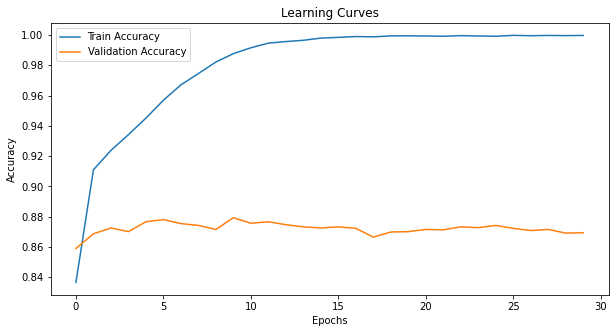

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()